In [81]:
import json, os, pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import re
pd.set_option('display.max_rows', None)

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def set_axis_style(ax, labels, x_label, y_label):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
def flatten(nested_list):
    return [item for sublist in nested_list for item in sublist]

def unzip(zipped_data):
    return list(zip(*zipped_data))


def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [82]:
results_sop = []
results_cs = []
results_time = []
for program in os.listdir("../evaluation-data/"):
#     if "max-dim" in program:
#         continue
    results_for_prog_sop = []
    results_for_prog_cs = []
    results_for_prog_time = []

    for ref in os.listdir(f"../evaluation-data/{program}"):
        with open(f'../evaluation-data/{program}/{ref}/aggr.json') as f:
            data = json.load(f)
            results_for_prog_sop.append(data['sum_of_pairs'])
            results_for_prog_cs.append(data['column_score'])
            results_for_prog_time.append(data['time_ms'])
    results_sop.append((program, results_for_prog_sop))
    results_cs.append((program, results_for_prog_cs))
    results_time.append((program, results_for_prog_time))

In [83]:
column_mapping = ['RV40', 'RV11', 'RV50', 'RV12', 'RV20', 'RV30']
df_sop = pd.DataFrame.from_items(results_sop, columns=column_mapping, orient='index')
df_cs = pd.DataFrame.from_items(results_cs, columns=column_mapping, orient='index')
df_time = pd.DataFrame.from_items(results_time, columns=column_mapping, orient='index')

In [84]:
df_sop = df_sop[sorted(df_sop.columns.tolist())].sort_index()
df_cs = df_cs[sorted(df_cs.columns.tolist())].sort_index()
df_time = df_time[sorted(df_time.columns.tolist())].sort_index()

In [85]:
results_sop_detail = {}
results_cs_detail = {}
results_time_detail = {}
for program in os.listdir("../evaluation-data/"):
#     if "Mafft-Fast" not in program and "Dialign" not in program and "spam-align-w-3_d-10" not in program:
#         continue
    results_for_prog_sop = defaultdict(list)
    results_for_prog_cs = defaultdict(list)
    results_for_prog_time = defaultdict(list)

    for ref in os.listdir(f"../evaluation-data/{program}"):
        for file in os.listdir(f"../evaluation-data/{program}/{ref}"):
            if not file.endswith("json") or "aggr" in file:
                continue
            with open(f"../evaluation-data/{program}/{ref}/{file}") as f:
                data = json.load(f)
                results_for_prog_sop[ref].append(data['sum_of_pairs'])
                results_for_prog_cs[ref].append(data['column_score'])
                results_for_prog_time[ref].append(data['time_ms'])

    results_sop_detail[program] = results_for_prog_sop
    results_cs_detail[program] = results_for_prog_cs
    results_time_detail[program] = results_for_prog_time

# Comparison of SoP and CS scores between Dialign, Mafft-Fast and spam-align

Spam-align has been run with a pattern set of 5 patterns with a weight of 3 and len of 13 each. This pattern set resulted in the best results on the balibase dataset.

Mafft-Fast stands for a call of Mafft (v7.310) with the arguments `--quiet --retree 1 --maxiterate 0`  representing the strategy `FFT-NS-1 (very fast; recommended for >2000 sequences; progressive method with a rough guide tree)`.  
Mafft-Accurate in the later tables stands for a call with the arguments `--quiet --localpair --maxiterate 1000` representig the strategy `L-INS-i (probably most accurate; recommended for <200 sequences; iterative refinement method incorporating local pairwise alignment information)`

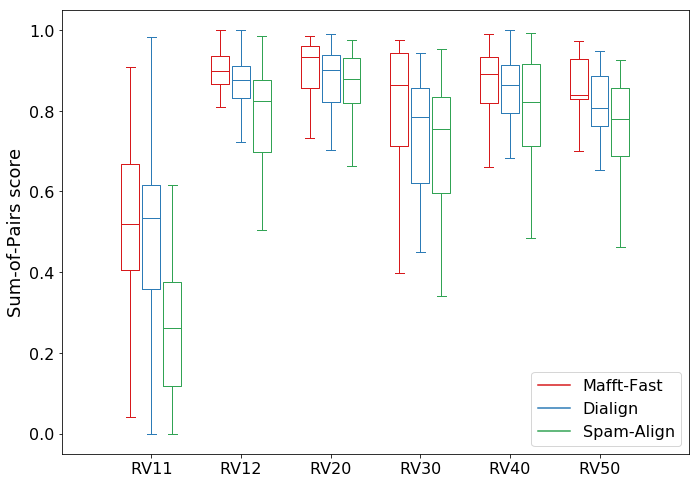

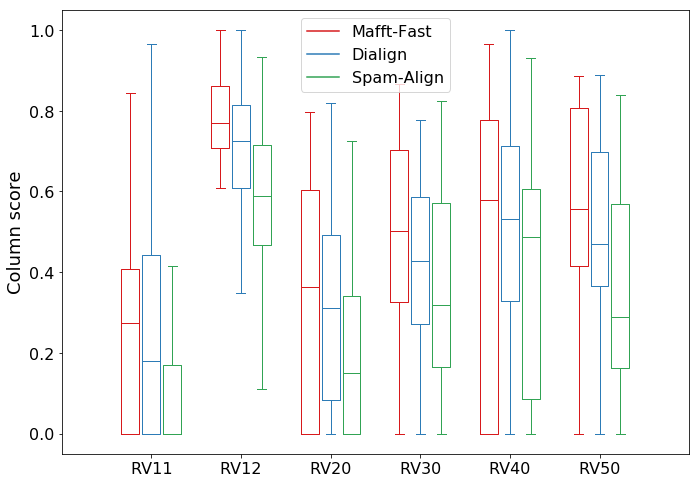

In [86]:

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

def plot_detail_data(data, ylabel, filename):
    ticks, data_mafft = unzip(sorted(data['Mafft-Fast'].items()))
    data_dialign = unzip(sorted(data['Dialign'].items()))[1]
    data_spam = unzip(sorted(data['spam-align-w-2_d-11'].items()))[1]
    
    fig = plt.figure(figsize=(10,7))
    bp1 = plt.boxplot(data_mafft, positions=np.array(range(len(data_mafft)))*3.0-0.7, sym='', widths=0.6)
    bp2 = plt.boxplot(data_dialign, positions=np.array(range(len(data_dialign)))*3.0, sym='', widths=0.6)
    bp3 = plt.boxplot(data_spam, positions=np.array(range(len(data_spam)))*3.0+0.7, sym='', widths=0.6)
    
    set_box_color(bp1, '#D7191C') # colors are from http://colorbrewer2.org/
    set_box_color(bp2, '#2C7BB6')
    set_box_color(bp3, '#31a354')

    plt.plot([], c='#D7191C', label='Mafft-Fast')
    plt.plot([], c='#2C7BB6', label='Dialign')
    plt.plot([], c='#31a354', label='Spam-Align')
    plt.legend()
    
    plt.xticks(range(0, len(ticks) * 3, 3), ticks)
    plt.xlim(-3, len(ticks)*3)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.savefig(filename, transparent=False)
plot_detail_data(results_sop_detail, 'Sum-of-Pairs score', 'sop-boxplot.png')
plot_detail_data(results_cs_detail, 'Column score', 'cs-boxplot.png')

## Sum of pairs score

In [87]:
df_sop

,RV11,RV12,RV20,RV30,RV40,RV50
Dialign,0.494482,0.851870,0.868279,0.739987,0.830939,0.804629
Mafft-Accurate,0.648562,0.937168,0.927191,0.862048,0.917403,0.899301
Mafft-Fast,0.521931,0.890052,0.885096,0.812195,0.842169,0.850608
spam-align-dyn-dim-w-2_d-10,0.126455,0.506980,0.532068,0.381787,0.435443,0.399528
spam-align-dyn-dim-w-2_d-11,0.150039,0.529455,0.528477,0.376477,0.400688,0.404538
spam-align-dyn-dim-w-2_d-12,0.158717,0.492123,0.536167,0.367205,0.444026,0.381854
spam-align-dyn-dim-w-2_d-13,0.166715,0.536008,0.539286,0.376744,0.464837,0.381768
spam-align-dyn-dim-w-2_d-14,0.160527,0.538340,0.506936,0.368505,0.472244,0.383988
spam-align-dyn-dim-w-2_d-15,0.155111,0.509228,0.493916,0.384813,0.442649,0.391487
spam-align-dyn-dim-w-2_d-16,0.160322,0.516868,0.522114,0.387748,0.439248,0.392221


In [88]:
df_sop.loc['spam-align-dyn-dim-w-2_d-10':].style.apply(highlight_max)

,RV11,RV12,RV20,RV30,RV40,RV50
spam-align-dyn-dim-w-2_d-10,0.126455,0.50698,0.532068,0.381787,0.435443,0.399528
spam-align-dyn-dim-w-2_d-11,0.150039,0.529455,0.528477,0.376477,0.400688,0.404538
spam-align-dyn-dim-w-2_d-12,0.158717,0.492123,0.536167,0.367205,0.444026,0.381854
spam-align-dyn-dim-w-2_d-13,0.166715,0.536008,0.539286,0.376744,0.464837,0.381768
spam-align-dyn-dim-w-2_d-14,0.160527,0.53834,0.506936,0.368505,0.472244,0.383988
spam-align-dyn-dim-w-2_d-15,0.155111,0.509228,0.493916,0.384813,0.442649,0.391487
spam-align-dyn-dim-w-2_d-16,0.160322,0.516868,0.522114,0.387748,0.439248,0.392221
spam-align-dyn-dim-w-2_d-3,0.0979306,0.386813,0.446215,0.311716,0.313796,0.294495
spam-align-dyn-dim-w-2_d-4,0.0923042,0.450563,0.476802,0.318327,0.364968,0.310538
spam-align-dyn-dim-w-2_d-5,0.092283,0.438549,0.469234,0.344098,0.395186,0.369129


In [99]:
df_sop_best = df_sop.loc[['Dialign','Mafft-Accurate', 'Mafft-Fast','spam-align-w-2_d-11', 'spam-align-w-2_d-13','spam-align-w-3_d-10'],:]
with open('df_sop_best.tex', 'w') as f:
    f.writelines(df_sop_best.to_latex())
    
df_cs_best = df_cs.loc[['Dialign','Mafft-Accurate', 'Mafft-Fast','spam-align-w-2_d-11', 'spam-align-w-2_d-13','spam-align-w-3_d-10'],:]
with open('df_cs_best.tex', 'w') as f:
    f.writelines(df_cs_best.to_latex())
    
df_time_best = df_time.loc[['Dialign','Mafft-Accurate', 'Mafft-Fast','spam-align-w-2_d-11', 'spam-align-w-2_d-13','spam-align-w-3_d-10'],:]
with open('df_time_best.tex', 'w') as f:
    f.writelines(df_time_best.to_latex())

## Column score

In [90]:
df_cs

,RV11,RV12,RV20,RV30,RV40,RV50
Dialign,0.267504,0.695353,0.320019,0.411190,0.484710,0.496890
Mafft-Accurate,0.438860,0.851518,0.486511,0.657281,0.627038,0.621163
Mafft-Fast,0.264334,0.763283,0.340603,0.467281,0.478159,0.528384
spam-align-dyn-dim-w-2_d-10,0.010330,0.187517,0.014883,0.002930,0.047285,0.058199
spam-align-dyn-dim-w-2_d-11,0.027889,0.230295,0.027221,0.015269,0.031004,0.049179
spam-align-dyn-dim-w-2_d-12,0.007959,0.190680,0.019299,0.003562,0.053513,0.046315
spam-align-dyn-dim-w-2_d-13,0.021166,0.215659,0.009651,0.016044,0.069491,0.033766
spam-align-dyn-dim-w-2_d-14,0.030976,0.235009,0.010254,0.007500,0.072794,0.040617
spam-align-dyn-dim-w-2_d-15,0.022058,0.185841,0.016920,0.012703,0.030028,0.035003
spam-align-dyn-dim-w-2_d-16,0.019044,0.194019,0.014067,0.011752,0.045205,0.024005


## Execution time in ms

In [91]:
df_time

,RV11,RV12,RV20,RV30,RV40,RV50
Dialign,543,1626,40116,85923,22494,23141
Mafft-Accurate,892,1276,14676,25992,33743,26462
Mafft-Fast,217,254,425,455,705,559
spam-align-dyn-dim-w-2_d-10,9,24,611,1256,277,338
spam-align-dyn-dim-w-2_d-11,9,24,588,1256,280,333
spam-align-dyn-dim-w-2_d-12,10,25,624,1291,296,339
spam-align-dyn-dim-w-2_d-13,10,26,605,1289,289,342
spam-align-dyn-dim-w-2_d-14,10,26,620,1322,297,352
spam-align-dyn-dim-w-2_d-15,11,29,660,1632,316,378
spam-align-dyn-dim-w-2_d-16,11,28,668,1428,317,372


In [92]:
def aggr_data(data, regex):
    aggr_data = defaultdict(dict)
    for key, values in data.items():
        m = re.search(regex, key)
        if m is None:
            continue
        w = int(m.group('w'))
        d = int(m.group('d'))
        aggr = np.mean(flatten(values.values()))
        aggr_data[w][d] = aggr 
    return aggr_data

two_dim_re = 'spam-align-w-(?P<w>\d)_d-(?P<d>\d+)'
sop_scores = aggr_data(results_sop_detail, two_dim_re)
cs_scores = aggr_data(results_cs_detail, two_dim_re)
time_aggr = aggr_data(results_time_detail, two_dim_re)

dyn_dim_re = 'spam-align-dyn-dim-w-(?P<w>\d)_d-(?P<d>\d+)'
sop_scores_dyn = aggr_data(results_sop_detail, dyn_dim_re)
cs_scores_dyn = aggr_data(results_cs_detail, dyn_dim_re)
time_aggr_dyn = aggr_data(results_time_detail, dyn_dim_re)


Max for spam-align w-2:  (0.6869453251961117, 11)
Max for spam-align w-3:  (0.6793929841995081, 10)
Max for spam-align w-4:  (0.6211672786851162, 9)
Max for spam-align w-5:  (0.5315992184687353, 8)
Max for spam-align w-6:  (0.4285114479703512, 7)
Max for spam-align w-7:  (0.34283719463113843, 5)
Mafft-Fast: 0.8005800015725726, Mafft-Accurate 0.8674247472612956, Dialign: 0.7690905059070182


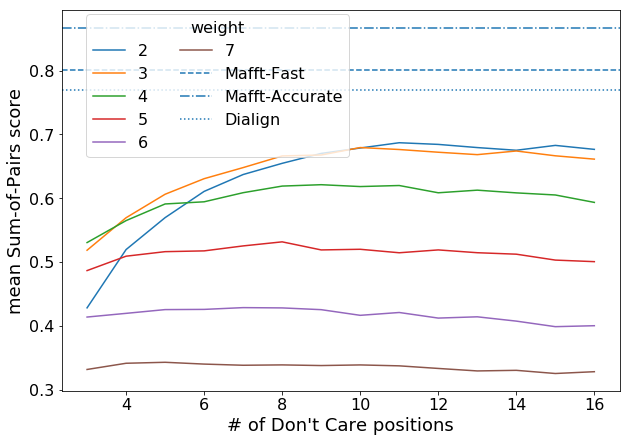

In [93]:
plt.figure(figsize=(10,7))
for weight, data in sorted(sop_scores.items()):
    x, y = unzip(sorted(data.items()))
    plt.plot(x, y,label=weight)
    print(f"Max for spam-align w-{weight}: ", max(zip(y, x)))
    
mafft_fast_sop = np.mean(flatten(results_sop_detail['Mafft-Fast'].values()))
mafft_acc_sop = np.mean(flatten(results_sop_detail['Mafft-Accurate'].values()))
dialign_sop = np.mean(flatten(results_sop_detail['Dialign'].values()))
print(f"Mafft-Fast: {mafft_fast_sop}, Mafft-Accurate {mafft_acc_sop}, Dialign: {dialign_sop}")
plt.axhline(mafft_fast_sop, ls='--', label='Mafft-Fast')
plt.axhline(mafft_acc_sop, ls='-.', label='Mafft-Accurate')
plt.axhline(dialign_sop, ls=':', label='Dialign')
plt.xlabel('# of Don\'t Care positions')
plt.ylabel('mean Sum-of-Pairs score')
plt.legend(title='weight', ncol=2, loc='upper left', bbox_to_anchor=(0.03, 1.01))
plt.savefig('sop-by-pattern-params.png', transparent=False)

Max for spam-align w-2:  (0.3345027737066016, 12)
Max for spam-align w-3:  (0.3247544332149583, 11)
Max for spam-align w-4:  (0.2626116736702392, 10)
Max for spam-align w-5:  (0.1591103908331561, 8)
Max for spam-align w-6:  (0.09017355084439038, 5)
Max for spam-align w-7:  (0.049019536018975816, 11)
Mafft-Fast: 0.4747533585977447, Mafft-Accurate 0.6168454383001395, Dialign: 0.4491659451999747


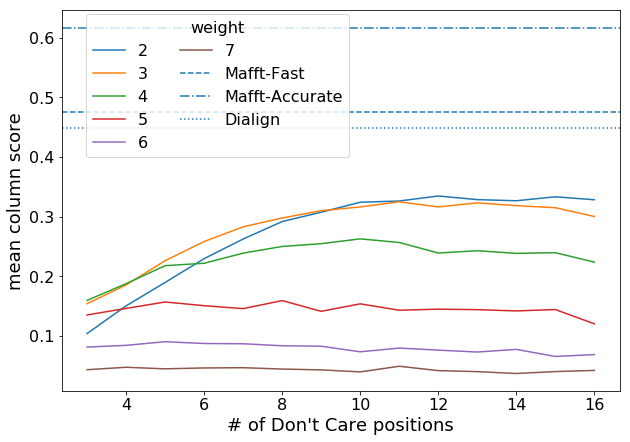

In [94]:
plt.figure(figsize=(10,7))
for weight, data in sorted(cs_scores.items()):
    x, y = unzip(sorted(data.items()))
    plt.plot(x, y,label=weight)
    print(f"Max for spam-align w-{weight}: ", max(zip(y, x)))

mafft_fast_cs = np.mean(flatten(results_cs_detail['Mafft-Fast'].values()))
mafft_acc_cs = np.mean(flatten(results_cs_detail['Mafft-Accurate'].values()))
dialign_cs = np.mean(flatten(results_cs_detail['Dialign'].values()))
print(f"Mafft-Fast: {mafft_fast_cs}, Mafft-Accurate {mafft_acc_cs}, Dialign: {dialign_cs}")
plt.axhline(mafft_fast_cs, ls='--', label='Mafft-Fast')
plt.axhline(mafft_acc_cs, ls='-.', label='Mafft-Accurate')
plt.axhline(dialign_cs, ls=':', label='Dialign')
plt.xlabel('# of Don\'t Care positions')
plt.ylabel('mean column score')
plt.legend(title='weight', ncol=2, loc='upper left', bbox_to_anchor=(0.03, 1.01))
plt.savefig('cs-by-pattern-params.png', transparent=False)

Mean time of Dialign: 26546.72018348624
Mean time of Mafft-Fast: 431.61467889908255
Mean time of Mafft-Accurate: 16277.114678899083


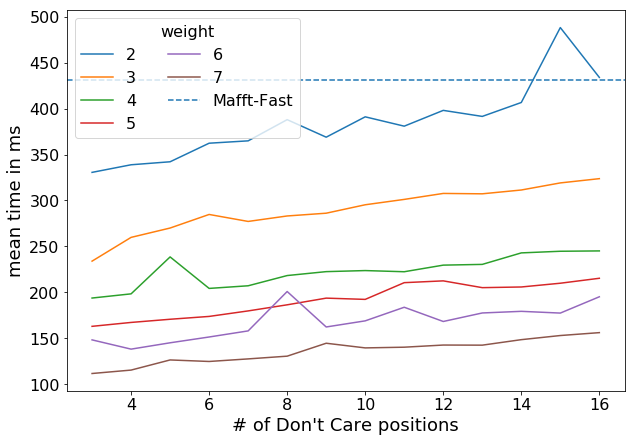

In [95]:
plt.figure(figsize=(10,7))
for weight, data in sorted(time_aggr.items()):
    x, y = unzip(sorted(data.items()))
    plt.plot(x, y,label=weight)
    
mafft_time = np.mean(flatten(results_time_detail['Mafft-Fast'].values()))
mafft_acc_time = np.mean(flatten(results_time_detail['Mafft-Accurate'].values()))
dialign_time = np.mean(flatten(results_time_detail['Dialign'].values()))
plt.axhline(mafft_time, ls='--', label='Mafft-Fast')
plt.xlabel('# of Don\'t Care positions')
plt.ylabel('mean time in ms')
plt.legend(title='weight', ncol=2, loc='upper left')
plt.savefig('time-by-pattern-params.png', transparent=False)
print(f'Mean time of Dialign: {dialign_time}')
print(f'Mean time of Mafft-Fast: {mafft_time}')
print(f'Mean time of Mafft-Accurate: {mafft_acc_time}')